# STR Adaptativo Indirecto

Incluye parte no adaptativa y parte adaptativa indirecta y directa con identificación RLS.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import scipy as sc
import math
import sympy as sp

## Planta a controlar y especificaciones

Obtener un controlador STR para el sistema de primer orden descripto por la transferencia

$$G(s)=\frac{1}{s(s+1)}$$

Se desea seguimiento a un modelo de segundo orden de frecuencia=1 rad/s, coeficiente de amortiguamiento 0.7, y ganancia de continua unitaria 
Considerar Ts=0.5s

In [2]:
# Especificación del modelo
# parámetros
wn = 1.0         # rad/s (natural frequency)
zeta = 0.7       # damping
Ts = 0.5         # periodo de muestreo

# Motor. Sistema continuo
s = ctrl.TransferFunction.s
K = 1.0
tau = 1.0
G = K / s / (tau * s + 1)

# Discretización
Gd = ctrl.c2d(G, Ts, method='zoh')
Gd.name = 'Planta'
print(f'Sistema discretizado: {Gd}')

# polos continuos
p1 = -zeta*wn + 1j*wn*math.sqrt(1 - zeta**2)
p2 = -zeta*wn - 1j*wn*math.sqrt(1 - zeta**2)

# polos discretos (mapeo exacto s -> z)
z1 = np.exp(p1 * Ts)
z2 = np.exp(p2 * Ts)

# Armo el modelo a seguir
Am = np.poly([z1, z2])              
Bm = np.polymul([1,0],[np.sum(Am)])

# Selección del modelo a seguir: tiene d0=1 (igual a la planta) y pide cancelar un cero de la planta de los que no es bueno andar cancelando
#Bm = [0.1761, 0]
#Am = [1, -1.3205, 0.4966]
Gm = ctrl.TransferFunction(Bm,Am,dt=Ts)
Gm.name='Modelo'
print(f'Ganancia de continua = {np.sum(Bm)/np.sum(Am)}')
print('Modelo a seguir',Gm)

Sistema discretizado: <TransferFunction>: Planta
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

    0.1065 z + 0.0902
  ----------------------
  z^2 - 1.607 z + 0.6065
Ganancia de continua = 1.0
Modelo a seguir <TransferFunction>: Modelo
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

        0.1761 z
  ---------------------
  z^2 - 1.32 z + 0.4966


## Implementación del STR adaptativo directo con cancelación de ceros 


/tmp/ipykernel_2483234/56347247.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k+1] = resp.y[:,-1]  # tomar valor al final del período


[[ 1.          1.          1.          1.          1.76106272]
 [ 1.          1.          1.          1.          1.76106272]
 [ 1.          1.          1.          1.          1.76106272]
 [ 1.          0.93884766  0.93884766  0.93884766  1.65336961]
 [ 1.          1.03120592  0.94843822  0.93856962  1.65287996]
 [ 1.          0.95643624  1.68429314  1.24043364  1.64919329]
 [ 1.          0.91665102  1.64885261  0.64871759  1.60737152]
 [ 1.          0.98391601  1.74765827  0.32992801  1.64456527]
 [ 1.          0.89343111  2.33553521 -0.59570824  1.63891919]
 [ 1.          0.90487504  2.44887138 -0.73513523  1.65771394]
 [ 1.          0.86928218  2.58635968 -0.9184129   1.65202726]
 [ 1.          0.87087329  2.61416717 -0.94739665  1.6567723 ]
 [ 1.          0.86063525  2.64117983 -0.98252523  1.65420225]
 [ 1.          0.8609777   2.6499173  -0.99098756  1.65576435]
 [ 1.          0.8571445   2.65755731 -1.00112779  1.65456321]
 [ 1.          0.85725767  2.66087517 -1.00422944  1.65

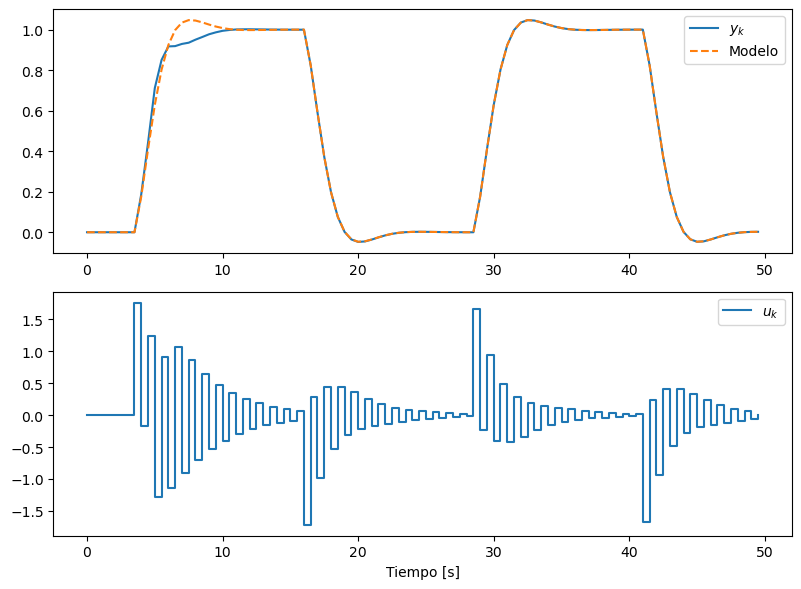

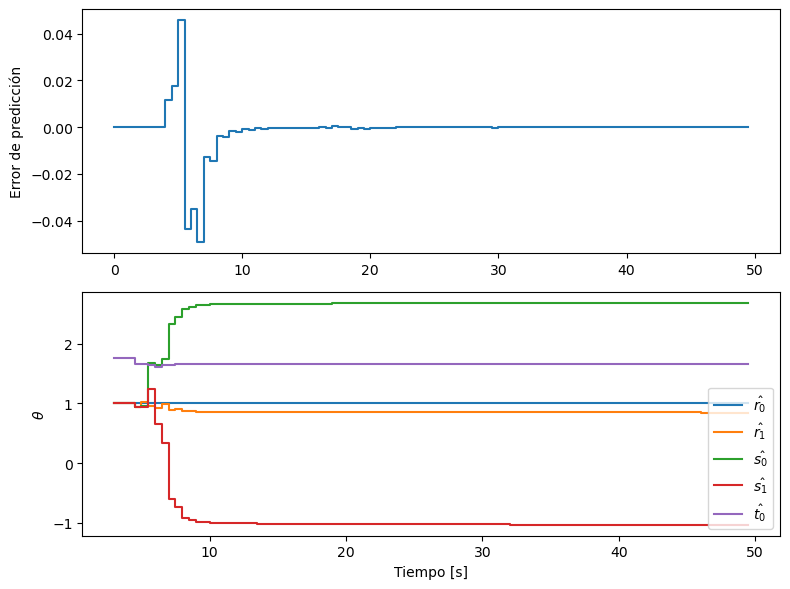

In [ ]:
def simular_STR_directo(G,Gm,t_final,Ts=0.5,sigma_v=0.1,theta_real=None):
    # --- Simulación ---
    t = np.arange(0, t_final, Ts)
    n_steps = len(t)

    # Señales
    np.random.seed(0)
    r = 0.5 * (sc.signal.square(2*np.pi * t / 25 - np.pi/4) + 1)  # de 0 a 1
    v = sigma_v*np.random.randn(n_steps)
    #v = sigma_v*np.ones(n_steps)
    y = np.zeros(n_steps)
    yf = np.zeros_like(y)
    y_hat = np.zeros_like(y)
    err = np.zeros_like(y)
    u = np.zeros_like(y)
    uf = np.zeros_like(y)
    param_hist = []    

    # Parámetros de la identificación
    lambda_ = 0.95
    d0 = 1

    # Coeficientes de los polinomios R_tilde y S_tilde
    nr = 2
    ns = 2
    theta_hat = np.ones(nr+ns)/10
    P = 100 * np.eye(nr+ns)          # matriz de incertidumbre grande

    Alc_bar = [1,0]
    Af = np.polymul(Alc_bar,Am)


    # Estado continuo
    Gss = ctrl.tf2ss(G)
    x = np.zeros(Gss.A.shape[0])
    for k in range(5, n_steps-1):
        # Nota memoria: y[k] = salida actual   u[k] entrada actual

        # Calculo las señales filtradas yf, uf
        yf[k] = -np.array(Af[1:]) @ np.array(yf[k-1:k-len(Af):-1]) + y[k-d0]
        uf[k] = -np.array(Af[1:]) @ np.array(uf[k-1:k-len(Af):-1]) + u[k-d0]

        # Armo el regresor
        phi = np.concatenate((uf[k:k-nl:-1], yf[k:k-nl:-1]))   # vector de regresores

        # Calculo y estimado y el error de estimación
        y_hat[k] = phi @ theta_hat
        err[k] = y[k] - y_hat[k]

        # Actualizo la estimación de parámetros
        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        # Calculo los polinomios del controlador
        R_tilde = theta_hat[0:nl]
        S_tilde = theta_hat[nl:2*nl]

        R = R_tilde/R_tilde[0]
        S = S_tilde/R_tilde[0]
        T = [np.sum(Alc_bar)*np.sum(Am)/R_tilde[0]]

        # Almaceno los parámetros estimados para graficar luego
        param = theta_hat.copy()
        param /= param[0]
        param = np.append(param.flatten(), T[0]) 
        param_hist.append(param)

        # Calcular u[k] según controlador discreto:
        # R(q)u = T(q)r - S(q)y
        # => u[k] = (1/R0) * ( ... )
        # Calculo la acción de control del STR
        u[k] = (np.dot(T,r[k:k-len(T):-1]) 
                - np.dot(S, y[k:k-len(S):-1]) 
                - np.dot(R[1:], u[k-1:k-len(R):-1]))/R[0] 
        
        # Simular dinámica continua con entrada u[k]
        # Equivale a usar un ZOH
        resp = ctrl.forced_response(Gss, [t[k-1], t[k]], U=u[k]+v[k], X0=x,return_states=True)
        x = resp.states[:,-1]
        y[k+1] = resp.y[:,-1]  # tomar valor al final del período

    param_hist = np.array(param_hist)
    print(param_hist)
    # Para comparar con el modelo
    t_m,y_m = ctrl.forced_response(Gm,t,U=r)

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(t,y,label='$y_k$')
    plt.plot(t_m,y_m,'--',label='Modelo')
    plt.legend()
    plt.subplot(2,1,2)
    plt.step(t,u,where='post',label='$u_k$')
    plt.xlabel('Tiempo [s]')
    plt.tight_layout()
    plt.legend()

    plt.figure(figsize=(8,6))
    plt.subplot(211)        
    plt.step(t,err,where='post')
    plt.ylabel('Error de predicción')
    plt.subplot(212)

    for idx_nr in range(0,nr):        
        plt.step(t[-len(param_hist):],param_hist[:,idx_nr], label=f"$\\hat{{r_{idx_nr}}}$",where='post')
    for idx_ns in range(0,ns):
        plt.step(t[-len(param_hist):],param_hist[:,nr+idx_ns], label=f"$\\hat{{s_{idx_ns}}}$",where='post')
    plt.step(t[-len(param_hist):],param_hist[:,nr+ns], label=f"$\\hat{{t_0}}$",where='post')

    plt.legend()
    plt.xlabel('Tiempo [s]')
    plt.ylabel('$\\theta$')
    plt.tight_layout()    
    plt.show()


simular_STR_directo(G,Gm,50,Ts,sigma_v=0)

## STR adaptativo indirecto sin cancelación

{r1: (a1*b1**2 - a2*b0*b1 + am1*ao*b0*b1 - am1*b1**2 - am2*ao*b0**2 + am2*b0*b1 - ao*b1**2)/(a1*b0*b1 - a2*b0**2 - b1**2), s0: (-a1**2*b1 + a1*a2*b0 + a1*am1*b1 + a1*ao*b1 - a2*am1*b0 - a2*ao*b0 + a2*b1 - am1*ao*b1 + am2*ao*b0 - am2*b1)/(a1*b0*b1 - a2*b0**2 - b1**2), s1: (-a1*a2*b1 + a1*am2*ao*b0 + a2**2*b0 - a2*am1*ao*b0 + a2*am1*b1 - a2*am2*b0 + a2*ao*b1 - am2*ao*b1)/(a1*b0*b1 - a2*b0**2 - b1**2)}
{t0: (am1 + am2 + 1)/(b0 + b1), t1: (am1*ao + am2*ao + ao)/(b0 + b1)}
S = [1.642282047708725, -0.7470100599100461]
T = [0.8952719877986779, 0.0]
R = [1, 0.11109696191902099]


/tmp/ipykernel_2437226/3543970554.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k+1] = resp.y[:,-1]  # tomar valor al final del período


-96


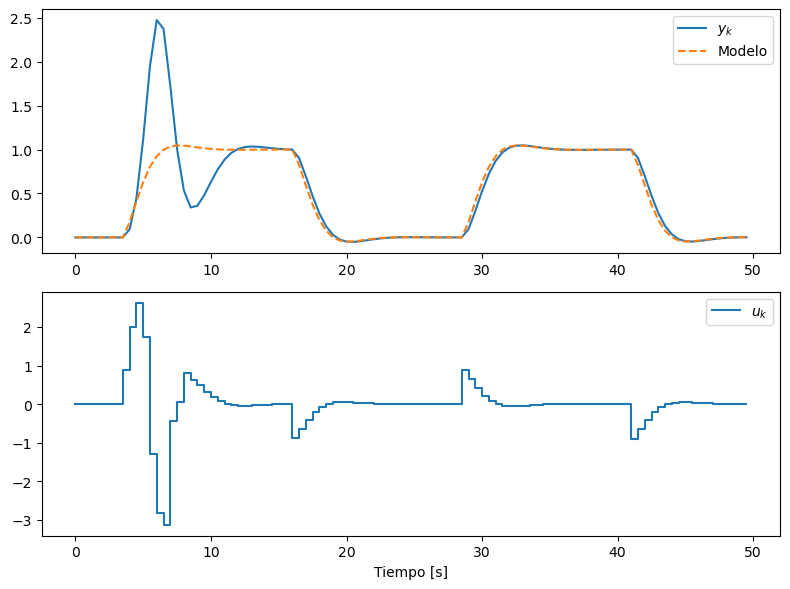

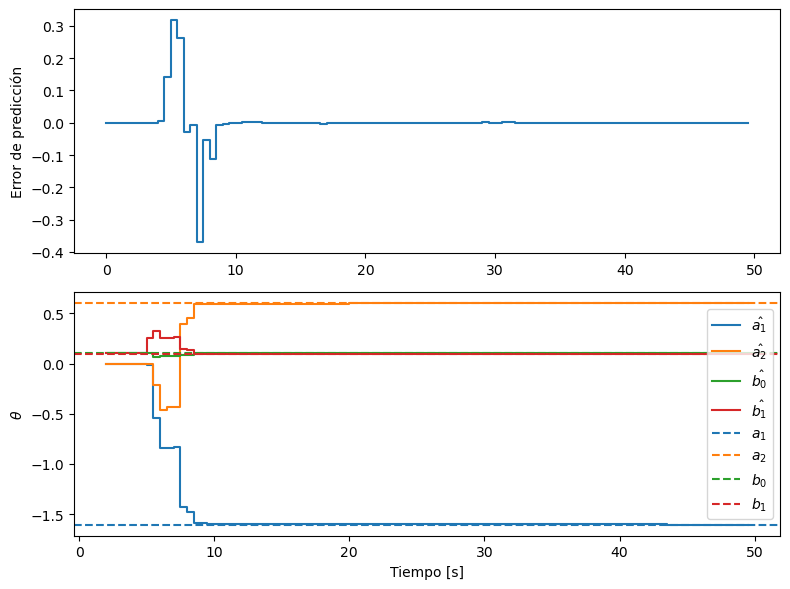

In [11]:
# Modelo de la planta (queda expresado en función de los parámetros que luego se identifican)
a1, a2, b0, b1 = sp.symbols('a1 a2 b0 b1')
A = z**2 + a1*z + a2
B = b0*z + b1

# Polinomios deseados (vamos sin cancelación porque el cero de B aparece en Bm)
# Ajusto los coefs de Bm para que la ganancia sea unitaria 
am1, am2 = sp.symbols('am1 am2')
Bm = (b0*z + b1)*(1+am1+am2)/(b0+b1)
Am = z**2 + am1*z + am2

# Factorizamos B
B_mas = 1 
B_menos = b0*z + b1

Bm_bar = sp.simplify(Bm/B_menos)

# Por compatibilidad resulta que el grado de Ac es 3, Am tiene grado 2 y por lo que Ao es grado 1
ao = sp.symbols('ao')
Ao = z + ao
# Además dim(R) = dim(S) = dim(T) = 1
# Como R = R_bar * B_mas => dim(R_bar)=1; Como R tiene que ser monico => R_bar = R
r1, s0, s1, t0, t1 = sp.symbols('r1 s0 s1 t0 t1')
R = z + r1
S = s0 *z + s1
T = t0 *z + t1

# Planteo la ec Diofantina y obtengo s0 y s1
SR_dict = resolver_polinomio(A * R + B * S - Ao * Am, [s0,s1,r1], z)
print(SR_dict)

# Obtengo t0 y t1
T_dict = resolver_polinomio(Ao*Bm_bar-T, [t0,t1], z)
print(T_dict)



# construir las funciones lambda
S_fun, T_fun, R_fun = build_lambda_from_mixed_dict(SR_dict | T_dict, [a1,a2,b0,b1,am1,am2,ao])

# evaluar con valores numéricos para el ejercicio en particular 
# ATENCION: los parámetros tienen este orden: a1,a2,b0,b1,am1,am2, ao
vals = ( -1.6065, 0.6065, 0.1065, 0.0902, -1.3205, 0.4966, 0  )

S_val = S_fun(*vals)
R_val = R_fun(*vals)
T_val = T_fun(*vals)

print("S =", S_val)
print("T =", T_val)
print("R =", R_val)

simular_STR_indirecto(G,Gm,S_fun,T_fun,R_fun,50,Ts,sigma_v=0.0)